<a href="https://colab.research.google.com/github/kosamate/brain-tumor-segmentation/blob/separated-patients/brain_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up kaggle creditentals.

In [ ]:
import os
import pathlib

DRIVE_PATH = pathlib.Path("/content/drive/MyDrive/brain")
!pip install -r "requirements.txt"
os.environ['KAGGLE_USERNAME'] = "" # add your username
os.environ['KAGGLE_KEY'] = "" # add your kaggle key

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
!python -V

Python 3.10.12


Downlaod the content of dataset

In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('mateuszbuda/lgg-mri-segmentation', path='/content/data', unzip=True, quiet=True)

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


Split the files to 3 different folder.

Distribution:
*   Test: 5 patients
*   Validation: 10 patients
*   Training: 95 patients





In [ ]:
import pathlib
file_names = sorted(pathlib.Path("/content/data/kaggle_3m").glob("TCGA*"))
train_path = pathlib.Path("/content/data/train")
val_path = pathlib.Path("/content/data/val")
test_path = pathlib.Path("/content/data/test")
train_path.mkdir(exist_ok=True)
val_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

for patient in file_names[0:5]:
    patient.rename(test_path / patient.name)
for patient in file_names[5:15]:
    patient.rename(val_path / patient.name)
for patient in file_names[15:-1]:
    patient.rename(train_path / patient.name)


Define the hyperparameters for the whole training process.

In [ ]:
import pathlib
import torch
class HyperParameters():
  BATCH_SIZE = 16
  IMAGE_SIZE = 256
  EPOCHS = 15
  LEARNING_RATE = 0.0002
  WEIGHTS_PATH = DRIVE_PATH

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


device: cuda:0


Define the transformation.

In [ ]:
from torchvision.transforms import v2
import torch

transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((256, 256)),
])
# TODO: Augemntation may be needed

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Define a dataset and create separated dataset for each phase of learning.

In [ ]:
from typing import NamedTuple
from torch.utils.data import Dataset
import pathlib
import skimage.io
import numpy as np
from torchvision.transforms import v2

class SliceInfo(NamedTuple):
  image: pathlib.Path
  mask: pathlib.Path

class BrainImageDataset(Dataset):
  def __init__(self, path: pathlib.Path, transfrom: v2.Transform) -> None:
    self._slices: list[SliceInfo] = []
    self._transform = transform

    for patient_dir in path.glob("TCGA*"):
      for mask_image in patient_dir.glob("*_mask.tif"):
        image_path = pathlib.Path(mask_image.as_posix().replace("_mask",""))
        slice_info = SliceInfo(image_path, mask_image)
        self._slices.append(slice_info)
    self._slices.sort(key=lambda i: i.image.name)

  def __getitem__(self, index) -> tuple:
    image_path, mask_path = self._slices[index]
    image = skimage.io.imread(image_path)
    mask = skimage.io.imread(mask_path, as_gray=True)

    image = np.array(image)
    mask = np.array(mask)
    info = image_path.name.split("/")[-1]

    image, mask = self._transform(image, mask)
    mask = mask[0,:,:].view((1, 256, 256))
    return image, mask, info

  def __len__(self) -> int:
    return len(self._slices)

train_ds = BrainImageDataset(pathlib.Path("/content/data/train"), transform)
val_ds = BrainImageDataset(pathlib.Path("/content/data/val"), transform)
test_ds = BrainImageDataset(pathlib.Path("/content/data/test"), transform)
print(f"data splitting:\ntrain\t{len(train_ds)}\nval\t{len(val_ds)}\ntest\t{len(test_ds)}")

data splitting:
train	3505
val	233
test	103


Helper functions to visualize the data and the result.

In [ ]:
from operator import imod
import matplotlib.pyplot as plt
import matplotlib.patches
import torch
import torch.nn as nn

def show_image(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index][0]).T)
    plt.title(image_ds[index][2])

def show_mask(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index][1]).T, cmap="gray")
    plt.title(image_ds[index][2])

def show_prediction(image_ds: BrainImageDataset,
                    index: int,
                    net: nn.Module,
                    threshold=0.8) -> None:
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].imshow(np.squeeze(image_ds[index][0]).T)
    ax[0, 0].set_title(image_ds[index][2])
    _remove_ticklabels(ax[0, 0])

    true = np.squeeze(image_ds[index][1]).T
    ax[0, 1].imshow(true, cmap="gray")
    ax[0, 1].set_title("ground truth")
    _remove_ticklabels(ax[0, 1])

    x = image_ds[index][0].view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(x)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    ax[1, 0].imshow(prediction, cmap="gray")
    ax[1, 0].set_title("prediction")
    _remove_ticklabels(ax[1, 0])

    empty_image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(0, 256):
      for j in range(0, 256):
        if true[i, j] > 0.5:
          empty_image_rgb[i, j, 0] = 255
        if prediction[i, j] > threshold:
          empty_image_rgb[i, j, 1] = 255


    ax[1, 1].imshow(empty_image_rgb)
    ax[1, 1].set_title("prediction overlay")
    ax[1, 1].text(-120, 20, "ground truth", color="red", fontsize=8)
    ax[1, 1].text(-120, 35, "prediction", color="green", fontsize=8)
    ax[1, 1].text(-120, 50, "overlay", color="yellow", fontsize=8)
    _remove_ticklabels(ax[1, 1])

def show_segmentation(
    image_ds: BrainImageDataset,
    index: int,
    net: nn.Module,
    threshold=0.8
):
    image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    brain_image = np.squeeze(image_ds[index][0]).T
    brain_mask = np.squeeze(image_ds[index][1]).T
    input = image_ds[index][0].view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(input)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    image_rgb[:, :, 0] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 1] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 2] = brain_image[:, :, 1] * 255

    for i in range(0, 256):
        for j in range(0, 256):
            _draw_outline(brain_mask, image_rgb, i, j, color="red")
            _draw_outline(prediction, image_rgb, i, j, color="green", th=threshold)

    im = plt.imshow(image_rgb)

    plt.title(image_ds[index][2])
    colors = ["red", "green", "yellow"]
    values = ["mask", "prediction", "perfect fit"]
    patches = [ matplotlib.patches.Patch(color=colors[i], label=values[i]) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def _remove_ticklabels(ax) -> None:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

def _draw_outline(mask, output, i ,j, color, th=0.5):
    channel = 0
    if color == "green":
        channel = 1
    if color == "blue":
        channel = 2
    if mask[i, j] > th:
        if i == 0 or j == 0 or i == 255 or j == 255:
            output[i, j, channel] = 255
        elif (mask[i-1, j] < th or mask[i+1, j] < th or
              mask[i, j-1] < th or mask[i, j+1] < th):
            output[i, j, channel] = 255


In [ ]:
show_prediction(test_ds, 108, net, threshold=0.9)

NameError: name 'net' is not defined

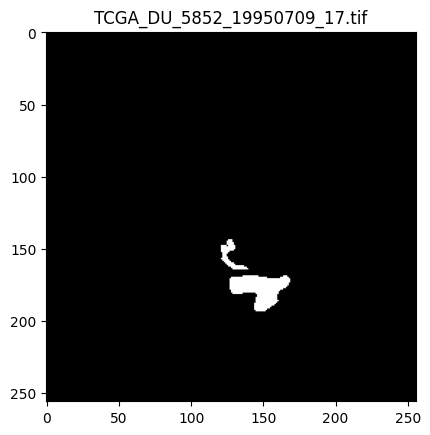

In [ ]:
show_mask(train_ds, 108)

Dataloaders

In [ ]:
import torch
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=True)

test_dl = DataLoader(dataset=test_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

val_dl = DataLoader(dataset=val_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

Define a model for the image segmentation.

In [ ]:
import collections
import torch
import torch.nn as nn

class BrainSegmentationModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    features = 32
    self.encoder1 = BrainSegmentationModel._block(3, features, name="enc1")
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder2 = BrainSegmentationModel._block(features, features * 2, name="enc2")
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder3 = BrainSegmentationModel._block(features * 2, features * 4, name="enc3")
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder4 = BrainSegmentationModel._block(features * 4, features * 8, name="enc4")
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck = BrainSegmentationModel._block(features * 8, features * 16, name="bottleneck")

    self.upconv4 = nn.ConvTranspose2d(
        features * 16, features * 8, kernel_size=2, stride=2
    )
    self.decoder4 = BrainSegmentationModel._block((features * 8) * 2, features * 8, name="dec4")
    self.upconv3 = nn.ConvTranspose2d(
        features * 8, features * 4, kernel_size=2, stride=2
    )
    self.decoder3 = BrainSegmentationModel._block((features * 4) * 2, features * 4, name="dec3")
    self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
    )
    self.decoder2 = BrainSegmentationModel._block((features * 2) * 2, features * 2, name="dec2")
    self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
    )
    self.decoder1 = BrainSegmentationModel._block(features * 2, features, name="dec1")

    self.conv = nn.Conv2d(
        in_channels=features, out_channels=1, kernel_size=1
    )

  def forward(self, x):
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))

      bottleneck = self.bottleneck(self.pool4(enc4))

      dec4 = self.upconv4(bottleneck)
      dec4 = torch.cat((dec4, enc4), dim=1)
      dec4 = self.decoder4(dec4)
      dec3 = self.upconv3(dec4)
      dec3 = torch.cat((dec3, enc3), dim=1)
      dec3 = self.decoder3(dec3)
      dec2 = self.upconv2(dec3)
      dec2 = torch.cat((dec2, enc2), dim=1)
      dec2 = self.decoder2(dec2)
      dec1 = self.upconv1(dec2)
      dec1 = torch.cat((dec1, enc1), dim=1)
      dec1 = self.decoder1(dec1)
      return torch.sigmoid(self.conv(dec1))

  @staticmethod
  def _block(in_channels, features, name):
      return nn.Sequential(
          collections.OrderedDict(
              [
                  (
                      name + "conv1",
                      nn.Conv2d(
                          in_channels=in_channels,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm1", nn.BatchNorm2d(num_features=features)),
                  (name + "relu1", nn.ReLU(inplace=True)),
                  (
                      name + "conv2",
                      nn.Conv2d(
                          in_channels=features,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm2", nn.BatchNorm2d(num_features=features)),
                  (name + "relu2", nn.ReLU(inplace=True)),
              ]
          )
      )

Load a previously saved model (Optional)

In [ ]:
import torch
net = BrainSegmentationModel()
if device == "cuda:0":
    net.load_state_dict(torch.load(HyperParameters.WEIGHTS_PATH / "separated1UNet.pt", weights_only=True))
else:
    net.load_state_dict(torch.load(HyperParameters.WEIGHTS_PATH / "separated1UNet.pt", map_location=torch.device('cpu'), weights_only=True))
net.to(device)
print("Model loaded")

Model loaded


Define lossses for the segmentation.

In [ ]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size(), f"pred: {y_pred.size()}, true: {y_true.size()}"
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.0 * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1.0 - dsc

class IoULoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        iou = ((y_pred * y_true).sum() + self.smooth) / (y_pred + y_true).sum()
        return 1.0 - iou

Initialize the network, loss and optimizer.

In [ ]:
import torch

net = BrainSegmentationModel()
net.to(device)

loss_func = DiceLoss()
loss_func.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=HyperParameters.LEARNING_RATE)

Training

In [ ]:
def log_summary(loss_list: list[float], prefix=""):
    print(f"{prefix}loss: {np.mean(loss_list)}\n")

def add_loss_by_patient(loss_valid: dict[str, list[float]], info: list[str], loss_func: nn.Module):
    for i, patient in enumerate(info):
            patient_id = patient.split("_")[2]
            if patient_id not in loss_valid:
                loss_valid.setdefault(patient_id, [])
            loss = loss_func(y_pred[i], y_true[i])
            loss_valid[patient_id].append(loss.detach().cpu().numpy())

loaders = {"train": train_dl, "valid": val_dl}
loss_train: dict[str, list[float]] = {}
loss_valid: dict[str, list[float]] = {}
history: dict[str, list[float]] = {"train": [], "valid": []}

step = 0
best_validation_dsc = 0

for epoch in range(HyperParameters.EPOCHS):
    print(f"===== EPOCH {epoch} =====\n")

    step += 1
    # training
    for i, data in enumerate(loaders["train"]):

        x, y_true, info = data
        x, y_true = x.to(device), y_true.to(device)
        net.train()
        optimizer.zero_grad()

        y_pred = net(x)

        loss = loss_func(y_pred, y_true)

        add_loss_by_patient(loss_train, info, loss_func)
        loss.backward()
        optimizer.step()

    # train loss
    patient_loss = []
    for patient in loss_train:
        patient_loss.append(np.mean(loss_train[patient]))
    log_summary(patient_loss, prefix="train_")
    history["train"].append(np.mean(patient_loss))
    loss_train = {}

    # validation
    for i, valid_data in enumerate(loaders["valid"]):
        x, y_true, info = valid_data
        x, y_true = x.to(device), y_true.to(device)

        net.eval()
        optimizer.zero_grad()

        with torch.no_grad():
            y_pred = net(x)

        add_loss_by_patient(loss_valid, info, loss_func)

    # valid loss
    patient_loss = []
    for patient in loss_valid:
        patient_loss.append(np.mean(loss_valid[patient]))
    log_summary(patient_loss, prefix="val_")
    history["valid"].append(np.mean(patient_loss))
    loss_valid = {}

print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 12.4 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762834 sha256=0964a59a1816b22a9163d45d3a491b82daac9b56b42365754a775de67d961fe1
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy
===== EPOCH 0 =====

train_loss: 0.9316742761568589

val_loss: 0.9813550114631653

===== EPOCH 1 =====

train_loss: 0.8664089931683107

val_loss: 0.9442951083183289

===== EPOCH 2 =====

train_loss: 0.721619525551796

val_loss: 0.813779354095459

===== EPOCH 3 =====

train_loss: 0.5216712848706679

val_loss: 0.5576920509338379

===== EPOCH 4 =====

train_loss: 0.36718962382186543

val_loss: 0.3448489308357239

===== EPOCH 5 =====

train_loss: 0.29276856536215

val_loss: 0.1753081977367401

===== EPO

Plot training loss

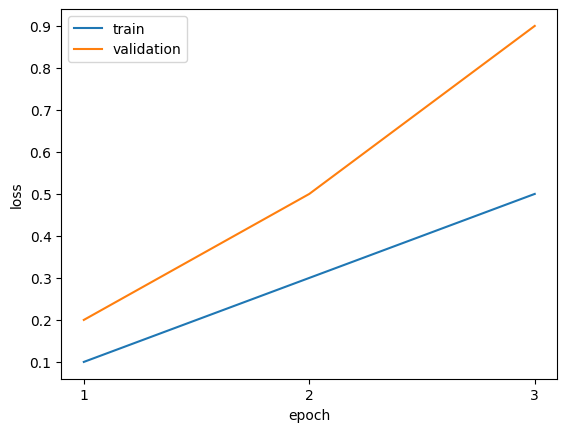

In [ ]:
import matplotlib.pyplot as plt
x_label = [int(x) for x in range(1, len(history["train"]) + 1)]
plt.plot(x_label, history["train"], label="train")
plt.plot(x_label, history["valid"], label="validation")
plt.xticks(x_label)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
dice_loss = DiceLoss()
iou_loss = IoULoss()

test_dice_loss = {}
test_iou_loss = {}
for i, data in enumerate(test_dl):
  x, y_true, info = data
  x, y_true = x.to(device), y_true.to(device)
  with torch.no_grad():
    y_pred = net(x)
    loss_dice = dice_loss(y_pred, y_true)
    loss_iou = iou_loss(y_pred, y_true)
    add_loss_by_patient(test_dice_loss, info, dice_loss)
    add_loss_by_patient(test_iou_loss, info, iou_loss)
print(f"iou loss: {np.mean([np.mean(v) for k,v in test_iou_loss.items()])}, dice loss: {np.mean([np.mean(v) for k,v in test_dice_loss.items()])}")

together: 0.4575604498386383
sep: 0.22021223604679108
together: 0.3900300860404968
sep: 0.1858362853527069
together: 0.24529670178890228
sep: 0.7740047574043274
together: 0.4222090542316437
sep: 0.15999460220336914
together: 0.43526899814605713
sep: 0.8087870478630066
together: 0.3744686245918274
sep: 0.2385692447423935
together: 0.5934435725212097
sep: 0.8459777235984802


Generate the segmentated data for each test patient.

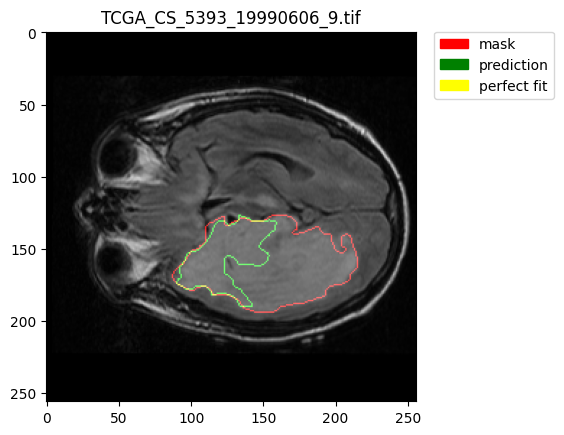

In [ ]:
import pathlib
for i, data in enumerate(test_ds):
    show_segmentation(test_ds, i, net, threshold=0.9)
    n = data[2].split("_")
    folder = pathlib.Path(HyperParameters.WEIGHTS_PATH) / n[3]
    folder.mkdir(exist_ok=True)
    plt.savefig(folder / n[4])

In [ ]:
import pathlib
file_names = sorted(pathlib.Path("/content/data/").glob("TCGA*"))
for file_name in file_names:
    n = file_name.name.split("_")
    folder = pathlib.Path(HyperParameters.WEIGHTS_PATH) / n[3]
    folder.mkdir(exist_ok=True)
    file_name.rename(folder / n[4])

OSError: [Errno 18] Invalid cross-device link: '/content/data/TCGA_CS_4941_19960909_1.tif' -> '/content/drive/MyDrive/brain/19960909/1.tif'

In [ ]:
torch.save(net.state_dict(), HyperParameters.WEIGHTS_PATH / "separated1UNet.pt")